In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

# Sklearn processing & feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # For handling sampling inside pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, f_classif

# Sampling techniques
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Model selection & evaluation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score

# Optuna for hyperparameter optimization
!pip install -U optuna optuna-integration[sklearn]  # Ensure latest version & scikit-learn integration
import optuna
from optuna.integration.sklearn import OptunaSearchCV




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00


In [ ]:

data = pd.read_csv('/content/dataset.csv')
print(data.shape)

(614, 13)


In [ ]:
data.info()

print(data.isnull().sum()/data.shape[0]*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2

There are 3 numerical coloumn with missing values
1. Loan amount
2. Loan amount term
3. credit history

Before we continue, let's seperate the label from the features first.

In [ ]:
X = data.drop(columns=['Loan_Status'])
y = data['Loan_Status']


Let's visualize the 3 numerical coloumn, to decide how can we deal with the missing values. The % of missing values are within reasonable range to apply imputer instead of dropping the coloumn.

Histogran & KDE

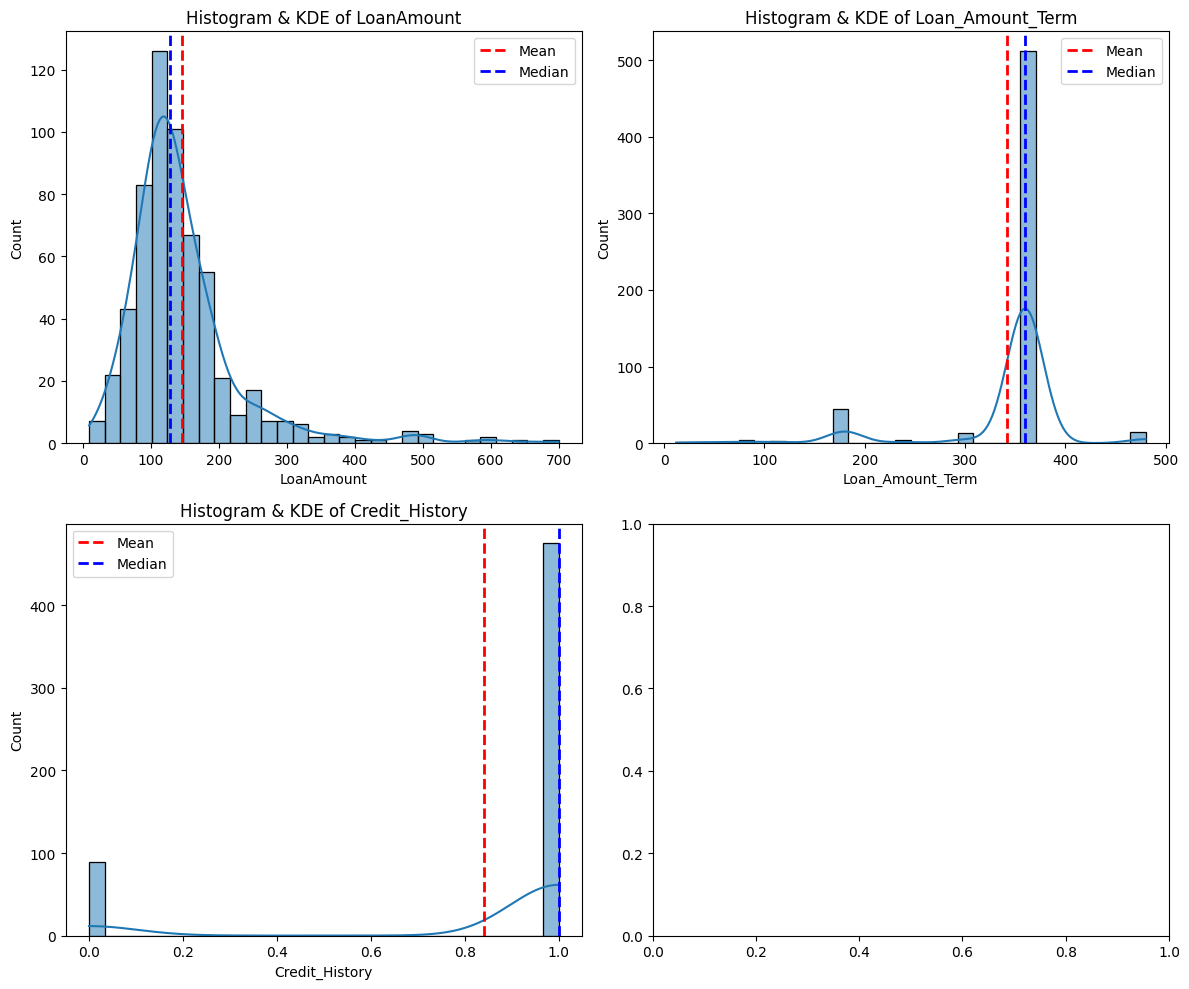

In [ ]:
numerical_cols = ["LoanAmount", "Loan_Amount_Term", "Credit_History"]

# Set plot style
fig, axes = plt.subplots(nrows=len(numerical_cols)//2+1 , ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot Histograms & KDE for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(X[col].dropna(), kde=True, bins=30, ax=axes[i])
    axes[i].axvline(X[col].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
    axes[i].axvline(X[col].median(), color='blue', linestyle='dashed', linewidth=2, label="Median")
    axes[i].set_title(f"Histogram & KDE of {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()


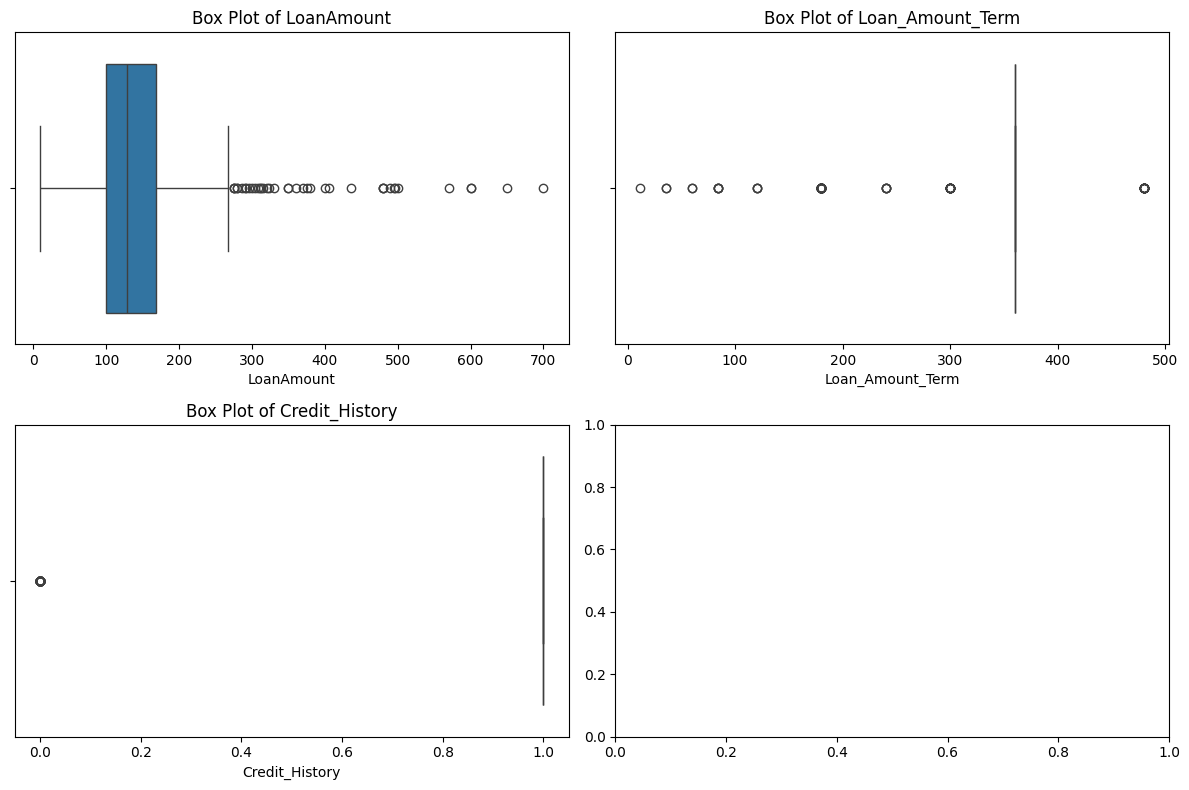

In [ ]:
# Set plot style
fig, axes = plt.subplots(nrows=len(numerical_cols)//2 + 1, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Plot Box Plots for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=X[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()


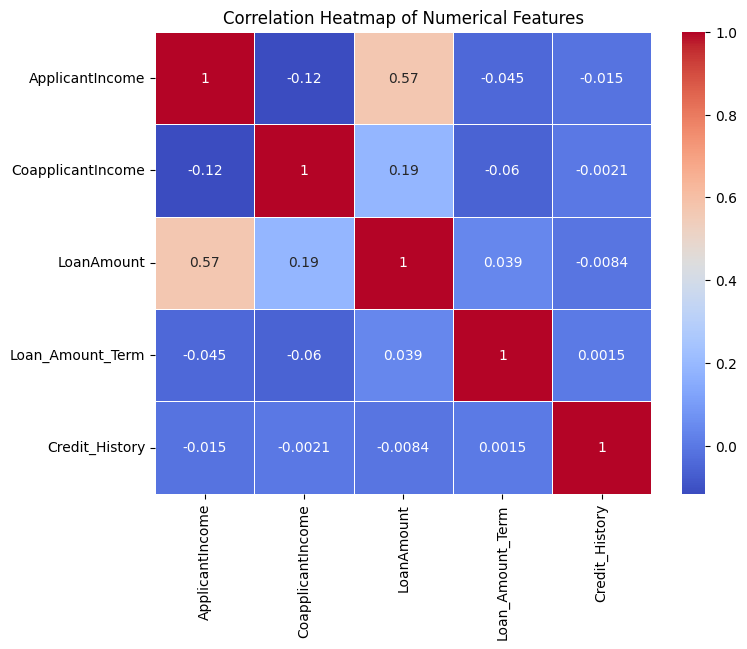

In [ ]:
#creating heatmap to check whether knn will be suitable for imputation, hence it is better to use all feature coloumns.
numerical_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
plt.figure(figsize=(8, 6))
# Select the columns specified in numerical_cols from the DataFrame X
sns.heatmap(X[numerical_cols].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


From histogram, all of these coloumns have skewed shape, and from boxplot, it shows all of these coloumns have outliers, which means the mean imputation will not be suitable. in fact, credit history is literaly binary, hence we will be using mode imputation for credit history. Looking at the Correlation heatmap, Loan amount coloumn has quite some correlation with other coloumns, hence knn imputation will be better suited. for loan amount term, since there is not much correlation, and the data is skewed, median imputation will be applied.

1. **Loan amount** : knn imputer
2. **Loan amount term**: median imputer
3. **credit history**: mode imputer

Now let's check histogram and boxplot for all coloumns, so we can decide what will be best scalar for each coloumn.

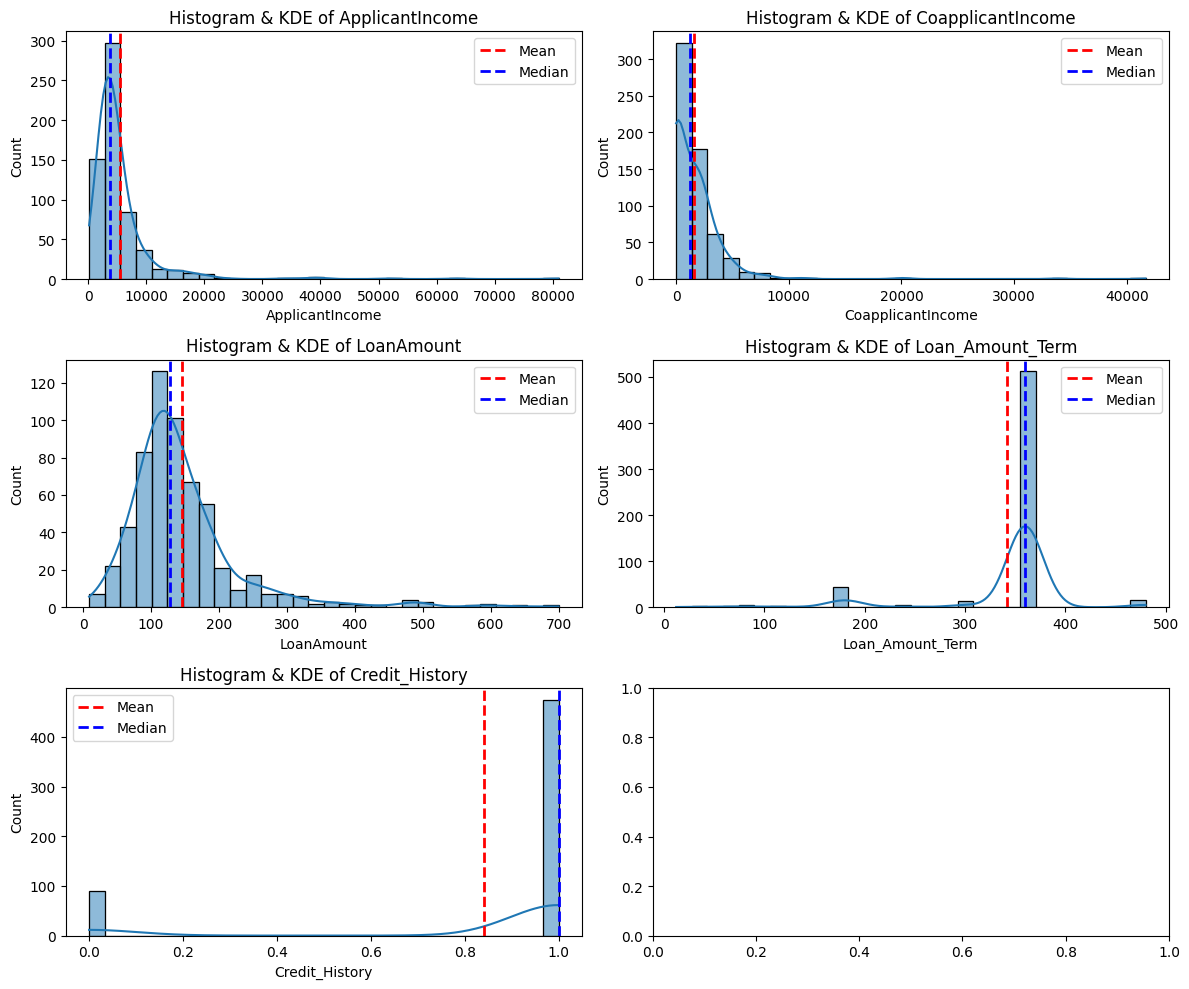

In [ ]:
numerical_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

# Set plot style
fig, axes = plt.subplots(nrows=len(numerical_cols)//2+1 , ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot Histograms & KDE for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(X[col].dropna(), kde=True, bins=30, ax=axes[i])
    axes[i].axvline(X[col].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
    axes[i].axvline(X[col].median(), color='blue', linestyle='dashed', linewidth=2, label="Median")
    axes[i].set_title(f"Histogram & KDE of {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

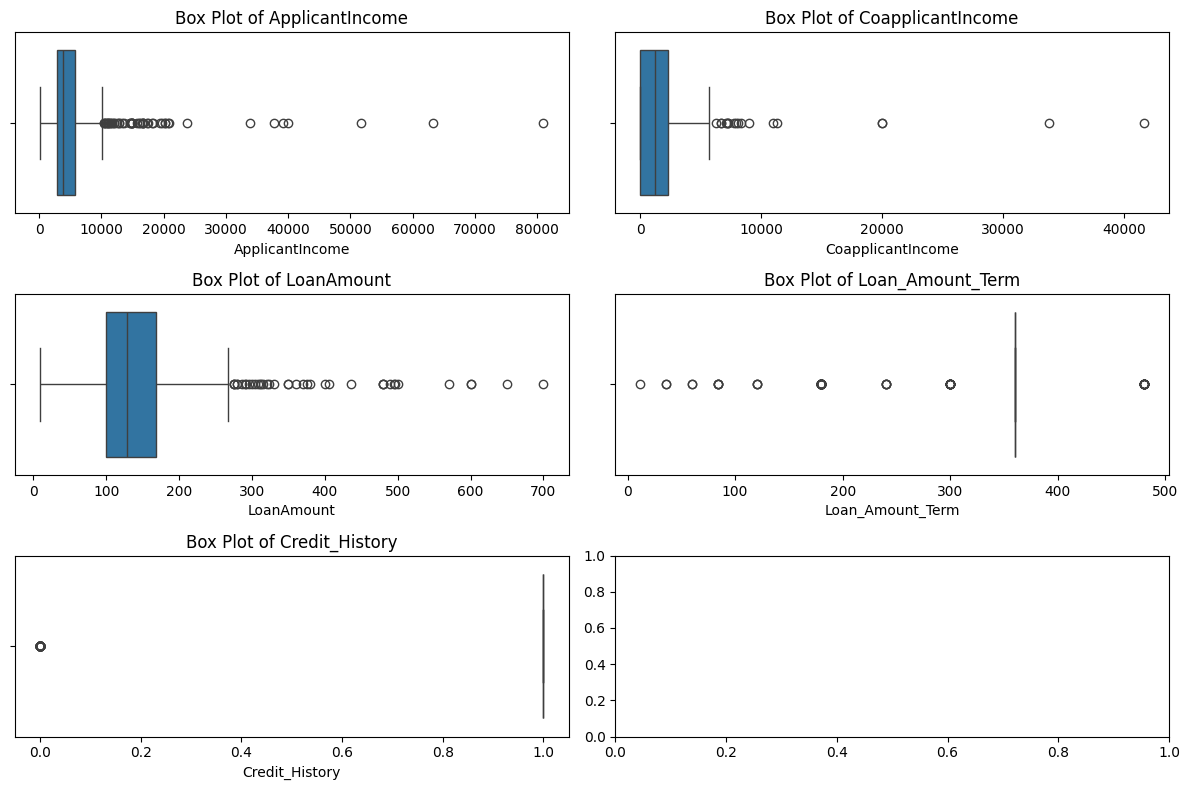

In [ ]:
# Set plot style
fig, axes = plt.subplots(nrows=len(numerical_cols)//2 + 1, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Plot Box Plots for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=X[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()


**Applicant income** : skewed data, so standard scalar is not a good choice, and too many outliers, so robust scalar will be better than min max.

**Loan amount** : Again skewed with many outlier, but also correlated with applicant income, meaning it will be a better choice to use the same scalar on both of these coloumns

**credit history** : binary, leave it as it is.

**coapplicant income** : Skewed but not very, has many outliers, hence robust scalar again.

**Loan amount term** : it looks like it has a set of discrete values. The range is big, so min max will be suitable to normalize it to a small range for better efficiency of classification.

Now let's check the categorial coloumns.

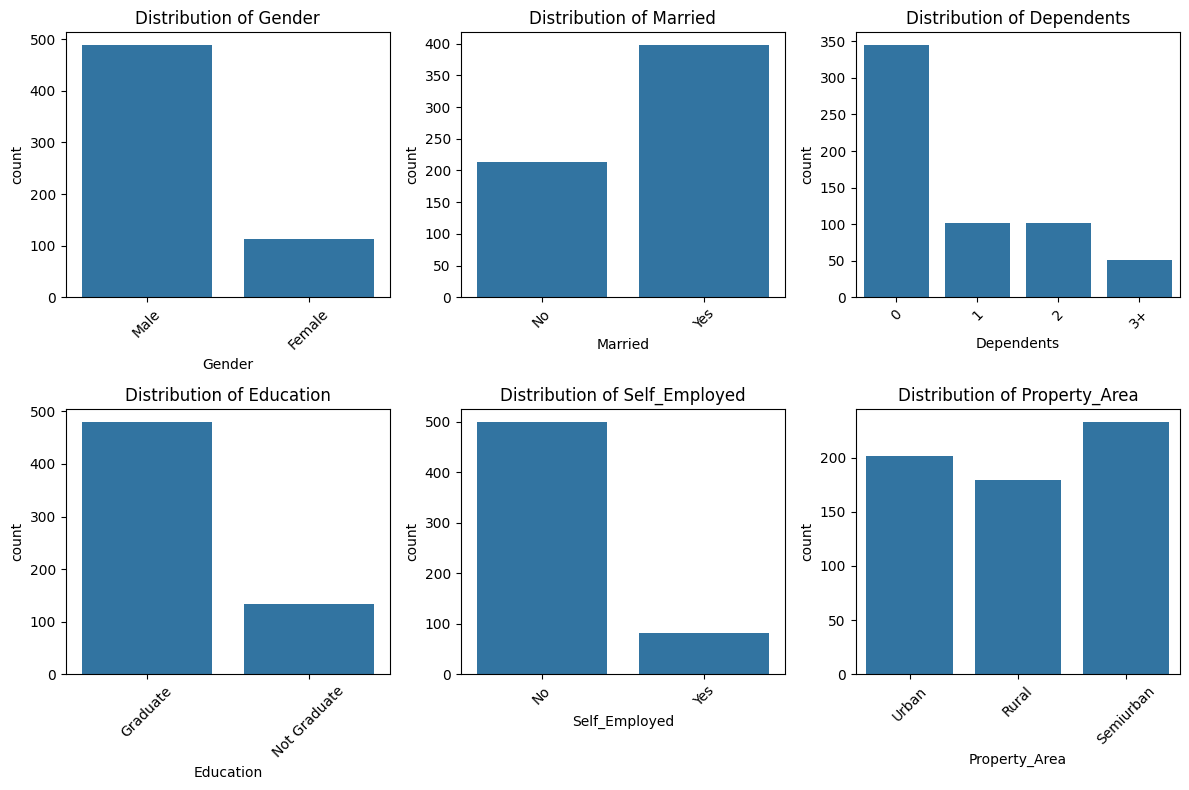

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]

plt.figure(figsize=(12, 8))

# Create bar plots for categorical columns
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=X[col])
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


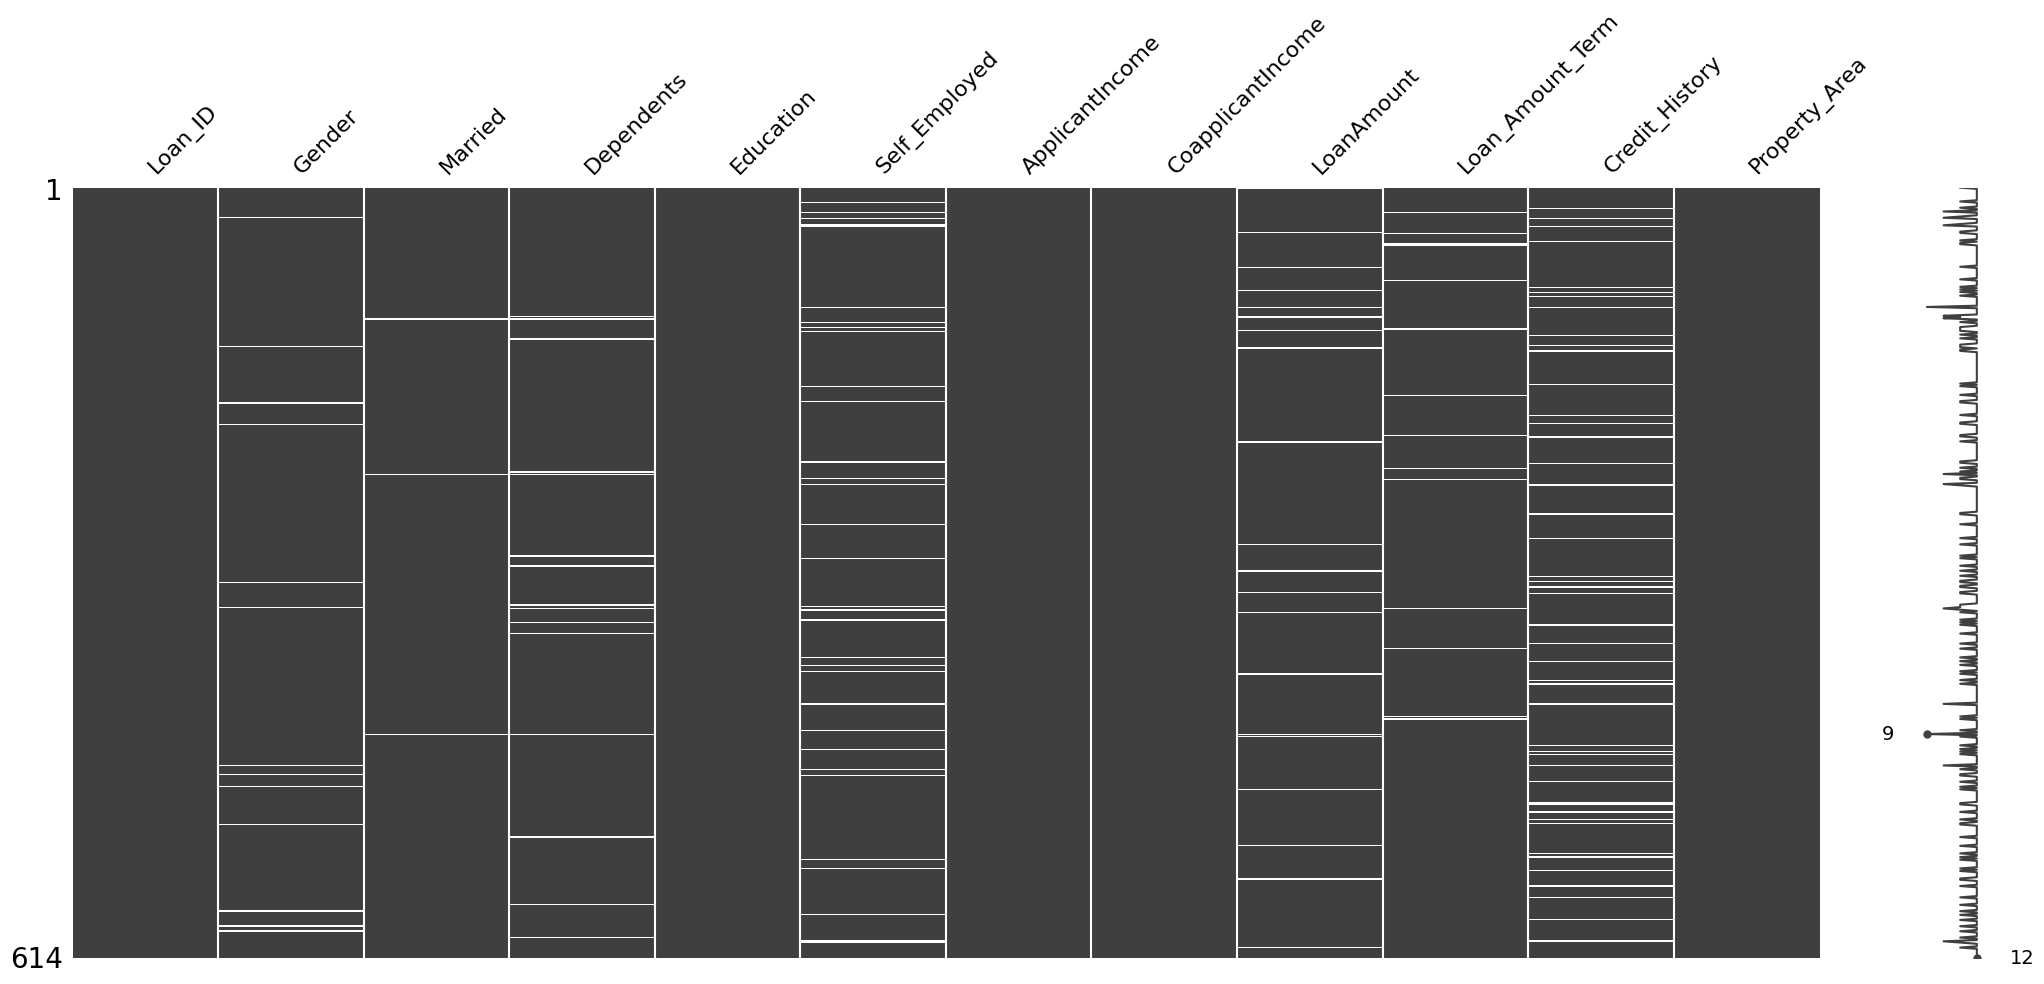

In [ ]:
import missingno as msno

msno.matrix(X)
plt.show()

It looks like mode imputation will do just fine, since there is very little missing values and coloumns with missing values has few features(mostly 2) with clearly one having very higher distribution ( from bar plot). One hot encoding will be suitable for all categorial coloumn, except for dependant, as number of dependant, well clearly is not categorial. For dependant coloumn, we will use integer encoding using ordinal encoder. Education can also benefit from integer encoding as graduate > non graduate.

let's create the coloumn transformer.

In [ ]:
# Define individual pipelines for each column
column_pipelines = {
    "LoanAmount": Pipeline([
        ("impute", KNNImputer()),
        ("scale", RobustScaler())
    ]),
    "Loan_Amount_Term": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", MinMaxScaler())
    ]),
    "Credit_History": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent"))  # No scaling needed for binary columns
    ]),
    "Gender": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "Married": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "Dependents": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=[["0", "1", "2", "3+"]]))
    ]),
    "Self_Employed": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "ApplicantIncome": Pipeline([
        ("scale", RobustScaler())  # No imputation needed
    ]),
    "CoapplicantIncome": Pipeline([
        ("scale", RobustScaler())  # No imputation needed
    ]),
    "Property_Area": Pipeline([
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "Education": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=[["Not Graduate", "Graduate"]]))
    ])
}

# Apply the column transformations
preprocessor = ColumnTransformer(
    transformers=[
        (col, pipeline, [col]) for col, pipeline in column_pipelines.items()
    ],
    remainder="drop"  # drops columns not explicitly listed
)

Before splitting, We have to transform categorial labels to numerical labels, and let's also check how many samples for each labels are there.

In [ ]:
# convert categorial labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
#unique counts for each labels
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 192, 1: 422}


The dataset looks very unbalanced, with 1 class having more than double the samples than the other class. Let's proceed to splitting the dataset, and make sure that we apply stratification during split, as the dataset is very unbalanced, without stratification, one class may never appear in one split.

In [ ]:
# Import the necessary function
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (491, 12)
Test data shape: (123, 12)


In [ ]:
X_train.head()
X_train.info()
print(X_train.columns)


<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 154 to 354
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            488 non-null    object 
 3   Dependents         483 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      464 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         471 non-null    float64
 9   Loan_Amount_Term   479 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 49.9+ KB
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount

Let's define the list of  dimension reduction method, samplers and classifiers. This is required as we will apply model selection using Optuna bayesian search, to find the best combination for the pipeline, along with the best hyperparameters for each combinations.

Here we are using 3 types of dimension reduction methods :    
* Linear projection methods : PCA, LDA, TSVD
* Non Linear projection method : KernelPCA ( Basically PCA but extends it using kernel method like in SVM to capture non linear patterns)
* Feature selection method : SelectKbest ( pretty simple name , as it selects k best features after carrying our some statistical tests)

In [ ]:
# Updated dimension reduction methods
dim_reduction_methods = {
    "PCA": PCA(n_components=10),  # Default, will be tuned later
    "KernelPCA": KernelPCA(n_components=10, kernel='rbf'),  # Using RBF kernel
    "LDA": LDA(n_components=1),  # LDA limited to n_classes - 1 components
    "SelectKBest": SelectKBest(score_func=f_classif, k=10),  # Select top k features
    "TSVD": TruncatedSVD(n_components=10)  # TruncatedSVD
}

Here we are using 3 types of samplers:

* over-samplers : Smote and Adasyn
* undersamplers : Randomundersampling ( self explainatory)
* hybrid of both over-sampler and undersampler : Smote_Tomek

In [ ]:
# Define available sampling methods
sampling_methods = {
    "SMOTE": SMOTE(sampling_strategy='auto', random_state=42),
    "ADASYN": ADASYN(sampling_strategy='auto', random_state=42),
    "RandomUnderSampling": RandomUnderSampler(sampling_strategy='auto', random_state=42),
    "SMOTE_Tomek": SMOTETomek(sampling_strategy='auto', random_state=42)
}

Here we list 4 different types of classifiers :

* Linear Models: LogisticRegression, Perceptron, SVC ( SVC in this case is both linear and non linear as during hyperparameter optimization, kernel method may be applied, in that case it will not be using the base model which is linear)
* Tree-Based Models: RandomForest, DecisionTree, GradientBoosting
* Probabilistic Models: NaiveBayes
* Instance-Based Models: KNN

In [ ]:
# Define available classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "Perceptron": Perceptron(random_state=42),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}


Now, we will create functions for dimension reduction method, samplers and classifiers, so each function can provide optuna's objective function with list of each components of the pipeline, along with range of hyperparameters suggestions for every single component. This will allow the objective function to make trials with each suggestions, to find the best possible combination.

Creating seperate functions instead of directly mentioning them inside the objective function to have better control, as this will allow easy debugging.

In [ ]:
def get_classifier(trial):
    classifier_name = trial.suggest_categorical("classifier", [
        "LogisticRegression", "Perceptron", "SVC", "RandomForest",
        "DecisionTree", "GradientBoosting", "NaiveBayes", "KNN"
    ])
    classifier_params = {}

    if classifier_name == "LogisticRegression":
        classifier_params["C"] = trial.suggest_float("lr_C", 1e-3, 1e2, log=True)
    elif classifier_name == "Perceptron":
        classifier_params["alpha"] = trial.suggest_float("perceptron_alpha", 1e-5, 1e-1, log=True)
    elif classifier_name == "SVC":
        classifier_params["C"] = trial.suggest_float("svc_C", 1e-3, 1e2, log=True)
        classifier_params["kernel"] = trial.suggest_categorical("svc_kernel", ["linear", "rbf", "poly"])
    elif classifier_name == "RandomForest":
        classifier_params["n_estimators"] = trial.suggest_int("rf_n_estimators", 50, 500, step=50)
        classifier_params["max_depth"] = trial.suggest_int("rf_max_depth", 3, 20)
    elif classifier_name == "DecisionTree":
        classifier_params["max_depth"] = trial.suggest_int("dt_max_depth", 3, 20)
    elif classifier_name == "GradientBoosting":
        classifier_params["n_estimators"] = trial.suggest_int("gb_n_estimators", 50, 500, step=50)
        classifier_params["learning_rate"] = trial.suggest_float("gb_learning_rate", 0.01, 0.5, log=True)
    elif classifier_name == "KNN":
        classifier_params["n_neighbors"] = trial.suggest_int("knn_n_neighbors", 3, 15)

    return classifiers[classifier_name].set_params(**classifier_params)


In [ ]:
def get_dim_reduction(trial):
    dim_reduction_name = trial.suggest_categorical("dim_reduction", ["None",
        "PCA", "KernelPCA", "LDA", "SelectKBest", "TSVD"
    ])
    if dim_reduction_name == "None":
        return None
    dim_reduction_params = {}


    if dim_reduction_name == "KernelPCA":
        dim_reduction_params["kernel"] = trial.suggest_categorical("kpca_kernel", ["linear", "rbf", "poly"])
    if dim_reduction_name == "LDA":
        dim_reduction_params["n_components"] = 1
    if dim_reduction_name == "SelectKBest":
        dim_reduction_params["k"] = trial.suggest_int("selectkbest_k", 2, 12)
    if dim_reduction_name == "TSVD":
        dim_reduction_params["n_components"] = trial.suggest_int("tsvd_n_components", 2, 12)

    return dim_reduction_methods[dim_reduction_name].set_params(**dim_reduction_params)

In [ ]:
def get_sampler(trial):
    sampling_name = trial.suggest_categorical("sampling", ["None",
        "SMOTE", "ADASYN", "RandomUnderSampling", "SMOTE_Tomek"
    ])
    if sampling_name == "None":
        return None

    sampling_params = {}

    if sampling_name == "SMOTE":
        sampling_params["sampling_strategy"] = trial.suggest_float("smote_sampling_strategy", 0.7, 1.0)
    if sampling_name == "ADASYN":
        sampling_params["sampling_strategy"] = trial.suggest_float("adasyn_sampling_strategy", 0.7, 1.0)
    if sampling_name == "RandomUnderSampling":
        sampling_params["sampling_strategy"] = trial.suggest_float("rus_sampling_strategy", 0.5, 0.9)
    if sampling_name == "SMOTE_Tomek":
        sampling_params["sampling_strategy"] = trial.suggest_float("smote_tomek_sampling_strategy", 0.7, 1.0)


    return sampling_methods[sampling_name].set_params(**sampling_params)

Now let's define the pipeline which will be used by the objective function during the search.

In [ ]:
def build_pipeline(trial):
    classifier = get_classifier(trial)
    dim_reduction = get_dim_reduction(trial)
    sampler = get_sampler(trial)

    return ImbPipeline([
        ("preprocessor", preprocessor),
        ("dim_reduction", dim_reduction),
        ("sampler", sampler),
        ("classifier", classifier)
    ])

Defining optuna's objective function. Adding pruning method, which will stop a trial if it is not worthwhile, saving resouces.

In [ ]:
def objective(trial):
    pipeline = build_pipeline(trial)

    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1", error_score="raise")
        mean_score = scores.mean()
    except ValueError as e:
        print(f"Trial failed due to ValueError: {e}")
        return None

    trial.report(mean_score, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return mean_score

In [ ]:
# Run Optuna optimization
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_study.db", study_name="ml_pipeline", load_if_exists=True)
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2025-02-16 14:31:04,007] A new study created in RDB with name: ml_pipeline
[I 2025-02-16 14:31:05,309] Trial 0 finished with value: 0.8741193115382504 and parameters: {'classifier': 'SVC', 'svc_C': 0.00919358163395616, 'svc_kernel': 'poly', 'dim_reduction': 'LDA', 'sampling': 'SMOTE', 'smote_sampling_strategy': 0.8479380051644245}. Best is trial 0 with value: 0.8741193115382504.
[I 2025-02-16 14:31:05,330] Trial 1 finished with value: 0.7029755567648163 and parameters: {'classifier': 'Perceptron', 'perceptron_alpha': 0.00016444046381275932, 'dim_reduction': 'None', 'sampling': 'ADASYN', 'adasyn_sampling_strategy': 0.9597388222375183}. Best is trial 0 with value: 0.8741193115382504.
[I 2025-02-16 14:31:06,200] Trial 2 finished with value: 0.8643707210530213 and parameters: {'classifier': 'DecisionTree', 'dt_max_depth': 6, 'dim_reduction': 'SelectKBest', 'selectkbest_k': 7, 'sampling': 'None'}. Best is trial 0 with value: 0.8741193115382504.
[I 2025-02-16 14:31:08,417] Trial 4 finishe

In [ ]:
# Retrieve best results per classifier
best_per_classifier = defaultdict(lambda: (None, -1))
for trial in study.trials:
    clf = trial.params["classifier"]
    if trial.value is not None and trial.value > best_per_classifier[clf][1]:
        best_per_classifier[clf] = (trial.params, trial.value)

# Print the best results
print("Best overall trial:", study.best_trial.params)
print("Best overall F1-score:", study.best_trial.value)
print("\nBest combination per classifier:")
for clf, (params, score) in best_per_classifier.items():
    print(f"Classifier: {clf}, Best F1-score: {score}, Params: {params}")

Best overall trial: {'classifier': 'SVC', 'svc_C': 47.36831621378038, 'svc_kernel': 'linear', 'dim_reduction': 'LDA', 'sampling': 'ADASYN', 'adasyn_sampling_strategy': 0.7002916817969569}
Best overall F1-score: 0.8741193115382504

Best combination per classifier:
Classifier: GradientBoosting, Best F1-score: 0.8628599213482373, Params: {'classifier': 'GradientBoosting', 'gb_n_estimators': 300, 'gb_learning_rate': 0.10372108269732355, 'dim_reduction': 'SelectKBest', 'selectkbest_k': 4, 'sampling': 'None'}
Classifier: SVC, Best F1-score: 0.8741193115382504, Params: {'classifier': 'SVC', 'svc_C': 47.36831621378038, 'svc_kernel': 'linear', 'dim_reduction': 'LDA', 'sampling': 'ADASYN', 'adasyn_sampling_strategy': 0.7002916817969569}
Classifier: Perceptron, Best F1-score: 0.7594642887426997, Params: {'classifier': 'Perceptron', 'perceptron_alpha': 0.004796844781247623, 'dim_reduction': 'None', 'sampling': 'None'}
Classifier: LogisticRegression, Best F1-score: 0.8656559091251725, Params: {'cla

Let's create a dictionary of the best combination for each classifiers, with their corresponding hyperparamater, so that we can later use this combinations to evaluate each classifiers on the test set, and later using an outer cross validation.

**NOTE:** The above values will not match the values in the dictionary downward, this is because the above optuna search was ran another time, as i have done this project on google colab, the file with saved model was removed after the runtime was autimatically stopped. The dictionary below uses the values found by optuna on the intial search.

In [ ]:
best_configs = [
    {"classifier": "DecisionTree", "params": {"max_depth": 6}, "dim_reduction": "SelectKBest", "dim_params": {"k": 4}, "sampling": "RandomUnderSampling", "sampling_params": {"sampling_strategy": 0.770}},
    {"classifier": "RandomForest", "params": {"n_estimators": 450, "max_depth": 6}, "dim_reduction": "SelectKBest", "dim_params": {"k": 3}, "sampling": "RandomUnderSampling", "sampling_params": {"sampling_strategy": 0.874}},
    {"classifier": "Perceptron", "params": {"alpha": 0.0001739}, "dim_reduction": "LDA", "dim_params": {}, "sampling": "SMOTE", "sampling_params": {"sampling_strategy": 0.703}},
    {"classifier": "NaiveBayes", "params": {}, "dim_reduction": "LDA", "dim_params": {}, "sampling": "RandomUnderSampling", "sampling_params": {"sampling_strategy": 0.881}},
    {"classifier": "KNN", "params": {"n_neighbors": 11}, "dim_reduction": "SelectKBest", "dim_params": {"k": 5}, "sampling": "SMOTE_Tomek", "sampling_params": {"sampling_strategy": 0.764}},
    {"classifier": "LogisticRegression", "params": {"C": 0.007239}, "dim_reduction": "LDA", "dim_params": {}, "sampling": "RandomUnderSampling", "sampling_params": {"sampling_strategy": 0.836}},
    {"classifier": "GradientBoosting", "params": {"n_estimators": 50, "learning_rate": 0.3106}, "dim_reduction": "SelectKBest", "dim_params": {"k": 4}, "sampling": "SMOTE_Tomek", "sampling_params": {"sampling_strategy": 0.767}},
    {"classifier": "SVC", "params": {"C": 0.331, "kernel": "rbf"}, "dim_reduction": "LDA", "dim_params": {}, "sampling": "SMOTE", "sampling_params": {"sampling_strategy": 0.734}}
]

Let's evaluate on the test set, and create a table for with all the metrics for each classifiers. Accuracy is not a good metric for this dataset as the dataset is really unbalanced, and accuracy tends to be biased towards the dominant class. F1 score is a better metrics, but we will look at all metrics either way.

In [ ]:
results = {}
for config in best_configs:
    classifier_name = config["classifier"]
    classifier = classifiers[classifier_name].set_params(**config["params"])

    dim_reduction_name = config["dim_reduction"]
    dim_reduction = dim_reduction_methods[dim_reduction_name].set_params(**config["dim_params"])

    sampling_name = config["sampling"]
    if sampling_name == "None":
        sampler = None
    else:
        sampler = sampling_methods[sampling_name].set_params(**config["sampling_params"])
    # Build the pipeline
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("dim_reduction", dim_reduction),
        ("sampler", sampler),
        ("classifier", classifier)
    ])

    # Train and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Get probability or decision function for AUC calculations
    if hasattr(classifier, "predict_proba"):
        y_scores = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class
    elif hasattr(classifier, "decision_function"):
        y_scores = pipeline.decision_function(X_test)  # Use decision function as scores
    else:
        y_scores = None  # Some classifiers neither support predict_proba nor decision_function

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores) if y_scores is not None else None
    pr_auc = average_precision_score(y_test, y_scores) if y_scores is not None else None

    # Store results
    results[classifier_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }



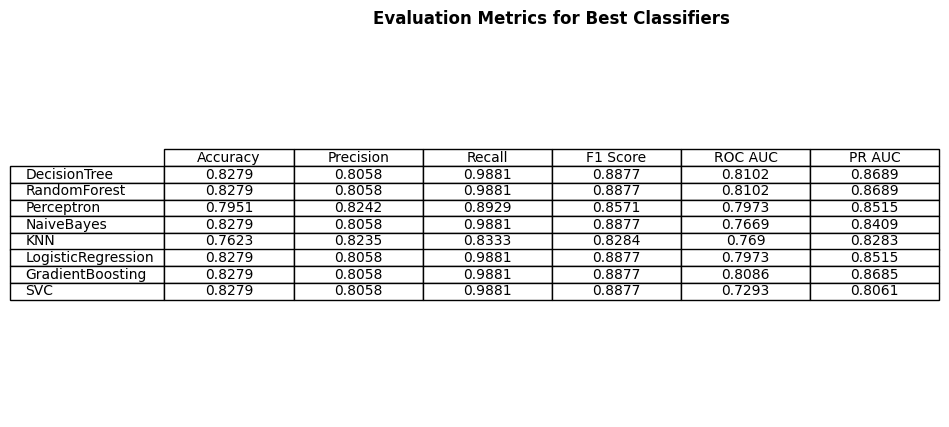

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results dictionary into a DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index")

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=results_df.round(4).values,  # Round values to 4 decimal places
                 colLabels=results_df.columns,  # Column headers
                 rowLabels=results_df.index,  # Row labels (Classifier names)
                 cellLoc='center',  # Center-align text
                 loc='center')  # Place table in the center

# Add a title
plt.title("Evaluation Metrics for Best Classifiers", fontsize=12, fontweight="bold")

# Show the table
plt.show()



Let's apply outer cross validation, and check the results. This should be more reliable than just using the test set, as the dataset is pretty small.

In [ ]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store overall results
results = {}

for config in best_configs:
    classifier_name = config["classifier"]
    classifier = classifiers[classifier_name].set_params(**config["params"])

    dim_reduction_name = config["dim_reduction"]
    dim_reduction = dim_reduction_methods[dim_reduction_name].set_params(**config["dim_params"])

    sampling_name = config["sampling"]
    if sampling_name == "None":
        sampler = None
    else:
        sampler = sampling_methods[sampling_name].set_params(**config["sampling_params"])

    # Store metrics across folds
    accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, pr_auc_list = [], [], [], [], [], []

    # Perform outer cross-validation
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]  # ✅ Works for NumPy arrays


        # Build the pipeline
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("dim_reduction", dim_reduction),
            ("sampler", sampler),
            ("classifier", classifier)
        ])

        # Train and evaluate
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Get probability or decision function for AUC calculations
        if hasattr(classifier, "predict_proba"):
            y_scores = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class
        elif hasattr(classifier, "decision_function"):
            y_scores = pipeline.decision_function(X_test)  # Use decision function as scores
        else:
            y_scores = None  # Some classifiers neither support predict_proba nor decision_function

        # Compute metrics for this fold
        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred, zero_division=0))
        recall_list.append(recall_score(y_test, y_pred, zero_division=0))
        f1_list.append(f1_score(y_test, y_pred))
        if y_scores is not None:
            roc_auc_list.append(roc_auc_score(y_test, y_scores))
            pr_auc_list.append(average_precision_score(y_test, y_scores))

    # Store the averaged results over all folds
    results[classifier_name] = {
        "Accuracy": np.mean(accuracy_list),
        "Precision": np.mean(precision_list),
        "Recall": np.mean(recall_list),
        "F1 Score": np.mean(f1_list),
        "ROC AUC": np.mean(roc_auc_list) if roc_auc_list else None,
        "PR AUC": np.mean(pr_auc_list) if pr_auc_list else None
    }

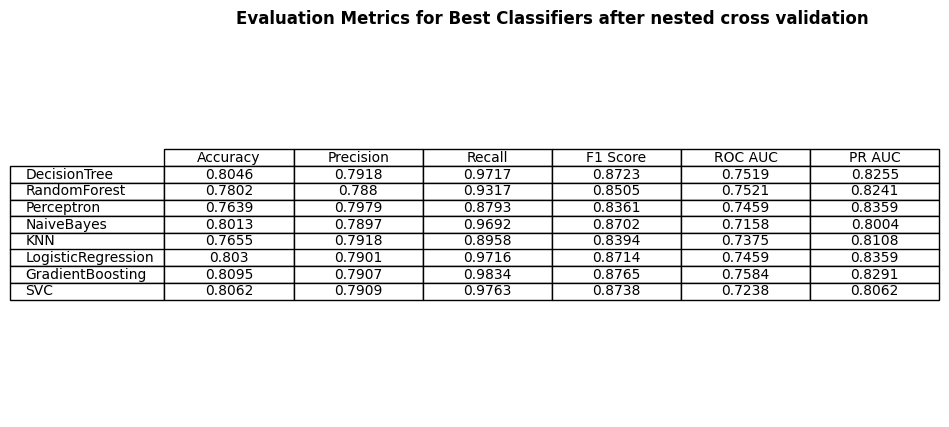

In [ ]:
# Convert results dictionary into a DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index")

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=results_df.round(4).values,  # Round values to 4 decimal places
                 colLabels=results_df.columns,  # Column headers
                 rowLabels=results_df.index,  # Row labels (Classifier names)
                 cellLoc='center',  # Center-align text
                 loc='center')  # Place table in the center

# Add a title
plt.title("Evaluation Metrics for Best Classifiers after nested cross validation", fontsize=12, fontweight="bold")

# Show the table
plt.show()

so far, looks like tree based model, especially gradient boosting did the best job, but let's visualize the results better.
Let's draw the ROC curve for both training and testing split.

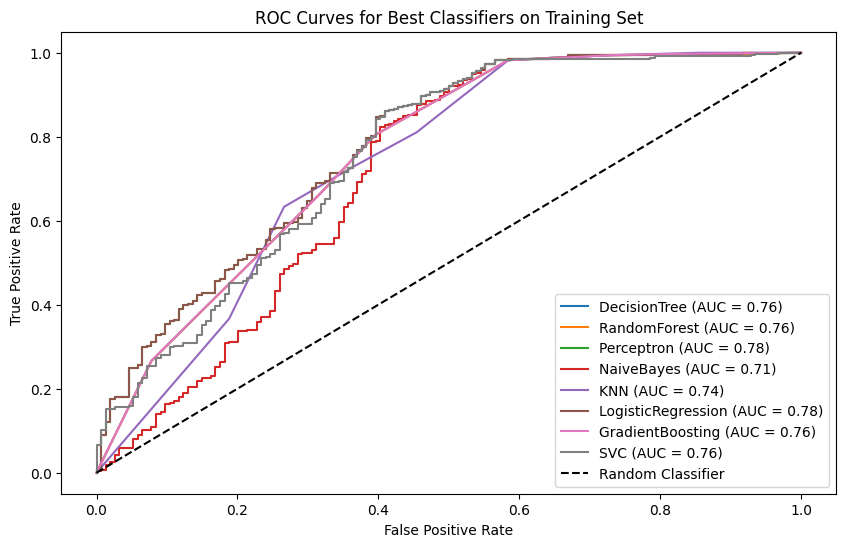

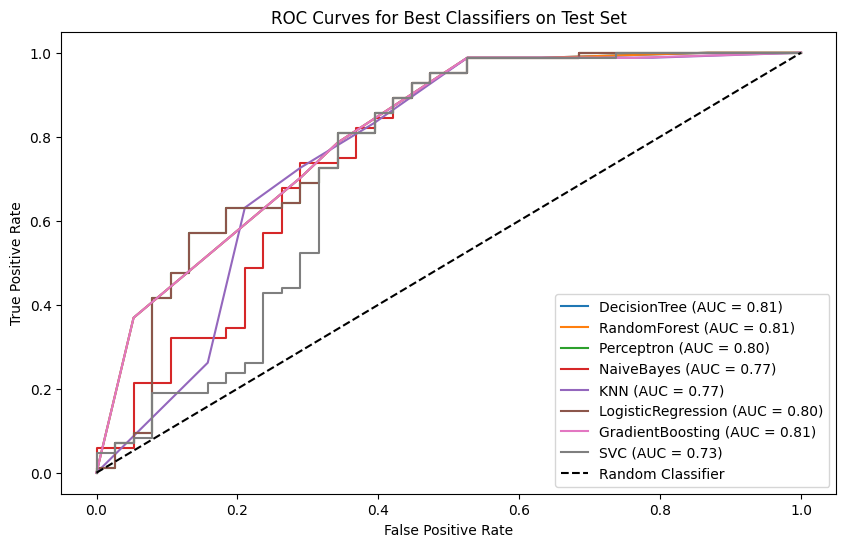

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curves for a given dataset (train or test)
def plot_roc_curves(X, y, dataset_name):
    plt.figure(figsize=(10, 6))
    plt.title(f"ROC Curves for Best Classifiers on {dataset_name} Set")

    for config in best_configs:
        classifier_name = config["classifier"]
        classifier = classifiers[classifier_name].set_params(**config["params"])

        dim_reduction_name = config["dim_reduction"]
        dim_reduction = dim_reduction_methods[dim_reduction_name].set_params(**config["dim_params"])

        sampling_name = config["sampling"]
        sampler = sampling_methods[sampling_name].set_params(**config["sampling_params"])

        # Build the pipeline
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("dim_reduction", dim_reduction),
            ("sampler", sampler),
            ("classifier", classifier)
        ])

        # Train the pipeline only once on the training set
        pipeline.fit(X_train, y_train)

        # Compute ROC curve on the provided dataset (train or test)
        if hasattr(classifier, "predict_proba"):
            y_scores = pipeline.predict_proba(X)[:, 1]  # Probability of positive class
        elif hasattr(classifier, "decision_function"):
            y_scores = pipeline.decision_function(X)  # Use decision function as scores
        else:
            continue  # Skip classifier if it doesn't support probability scores

        fpr, tpr, _ = roc_curve(y, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{classifier_name} (AUC = {roc_auc:.2f})")

    # Plot random baseline
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Random Classifier")

    # Finalize plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Run the function separately for train and test sets
plot_roc_curves(X_train, y_train, "Training")
plot_roc_curves(X_test, y_test, "Test")




The stairway like shape tells us that the dataset is very unbalanced, which we know as there are many samples for one class and less samples for another class. But even then, Tree based classifiers did pretty well, considering the curve looks pretty smooth, not completely but way better than the linerar classifers. But in general, ROC curve does not give us that well information for unbalanced dataset, as ROC considers both true positive rate and false positive rate and in an unbalanced dataset, false positive rate can be misleading, as false positive = false positive /( false positive + true negatives), and number of true negative can be misleading because of unbalaced classes. A better visualization curve would be Precision recall curve, let's draw that.

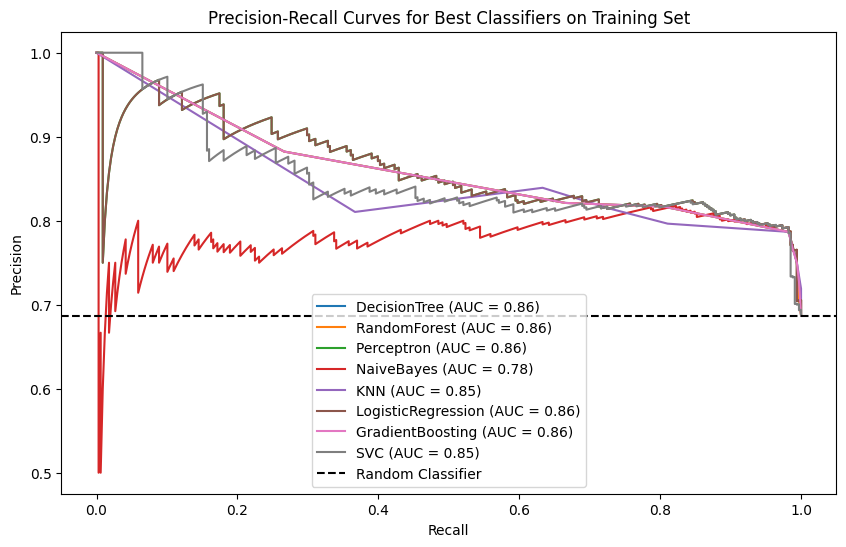

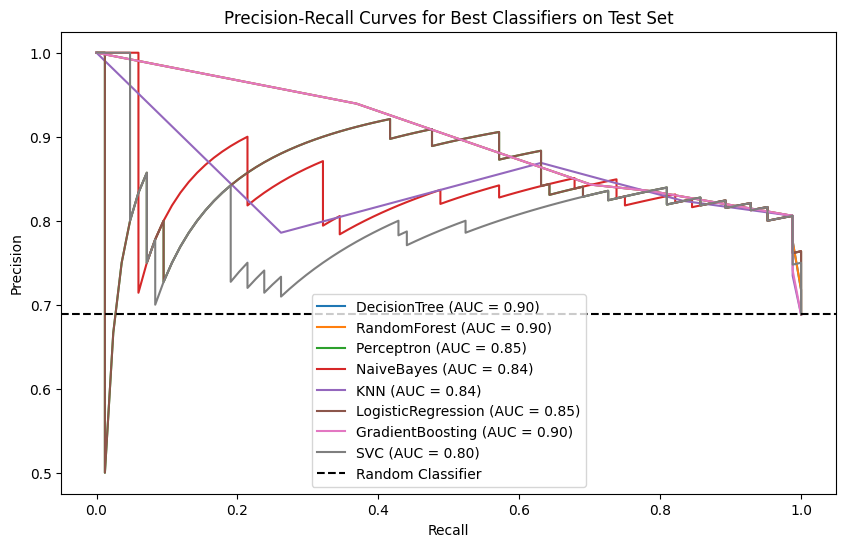

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Function to plot PR curves for a given dataset (train or test)
def plot_pr_curves(X, y, dataset_name):
    plt.figure(figsize=(10, 6))
    plt.title(f"Precision-Recall Curves for Best Classifiers on {dataset_name} Set")

    for config in best_configs:
        classifier_name = config["classifier"]
        classifier = classifiers[classifier_name].set_params(**config["params"])

        dim_reduction_name = config["dim_reduction"]
        dim_reduction = dim_reduction_methods[dim_reduction_name].set_params(**config["dim_params"])

        sampling_name = config["sampling"]
        sampler = sampling_methods[sampling_name].set_params(**config["sampling_params"])

        # Build the pipeline
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("dim_reduction", dim_reduction),
            ("sampler", sampler),
            ("classifier", classifier)
        ])

        # Train the pipeline only once on the training set
        pipeline.fit(X_train, y_train)

        # Compute Precision-Recall curve on the provided dataset (train or test)
        if hasattr(classifier, "predict_proba"):
            y_scores = pipeline.predict_proba(X)[:, 1]  # Probability of positive class
        elif hasattr(classifier, "decision_function"):
            y_scores = pipeline.decision_function(X)  # Use decision function as scores
        else:
            continue  # Skip classifier if it doesn't support probability scores

        precision, recall, _ = precision_recall_curve(y, y_scores)
        pr_auc = auc(recall, precision)

        # Plot PR curve
        plt.plot(recall, precision, label=f"{classifier_name} (AUC = {pr_auc:.2f})")

    # Plot baseline (random classifier)
    plt.axhline(y=sum(y) / len(y), color='black', linestyle='--', label="Random Classifier")

    # Finalize plot
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Run the function separately for train and test sets
plot_pr_curves(X_train, y_train, "Training")
plot_pr_curves(X_test, y_test, "Test")


Yet again, the tree based clasifiers did the best, and not to mention the AUC of precision recall graph is higher on testing set than training, showing that it generalizes better on unseen data. Let's draw confusion matrix  for all classifiers .

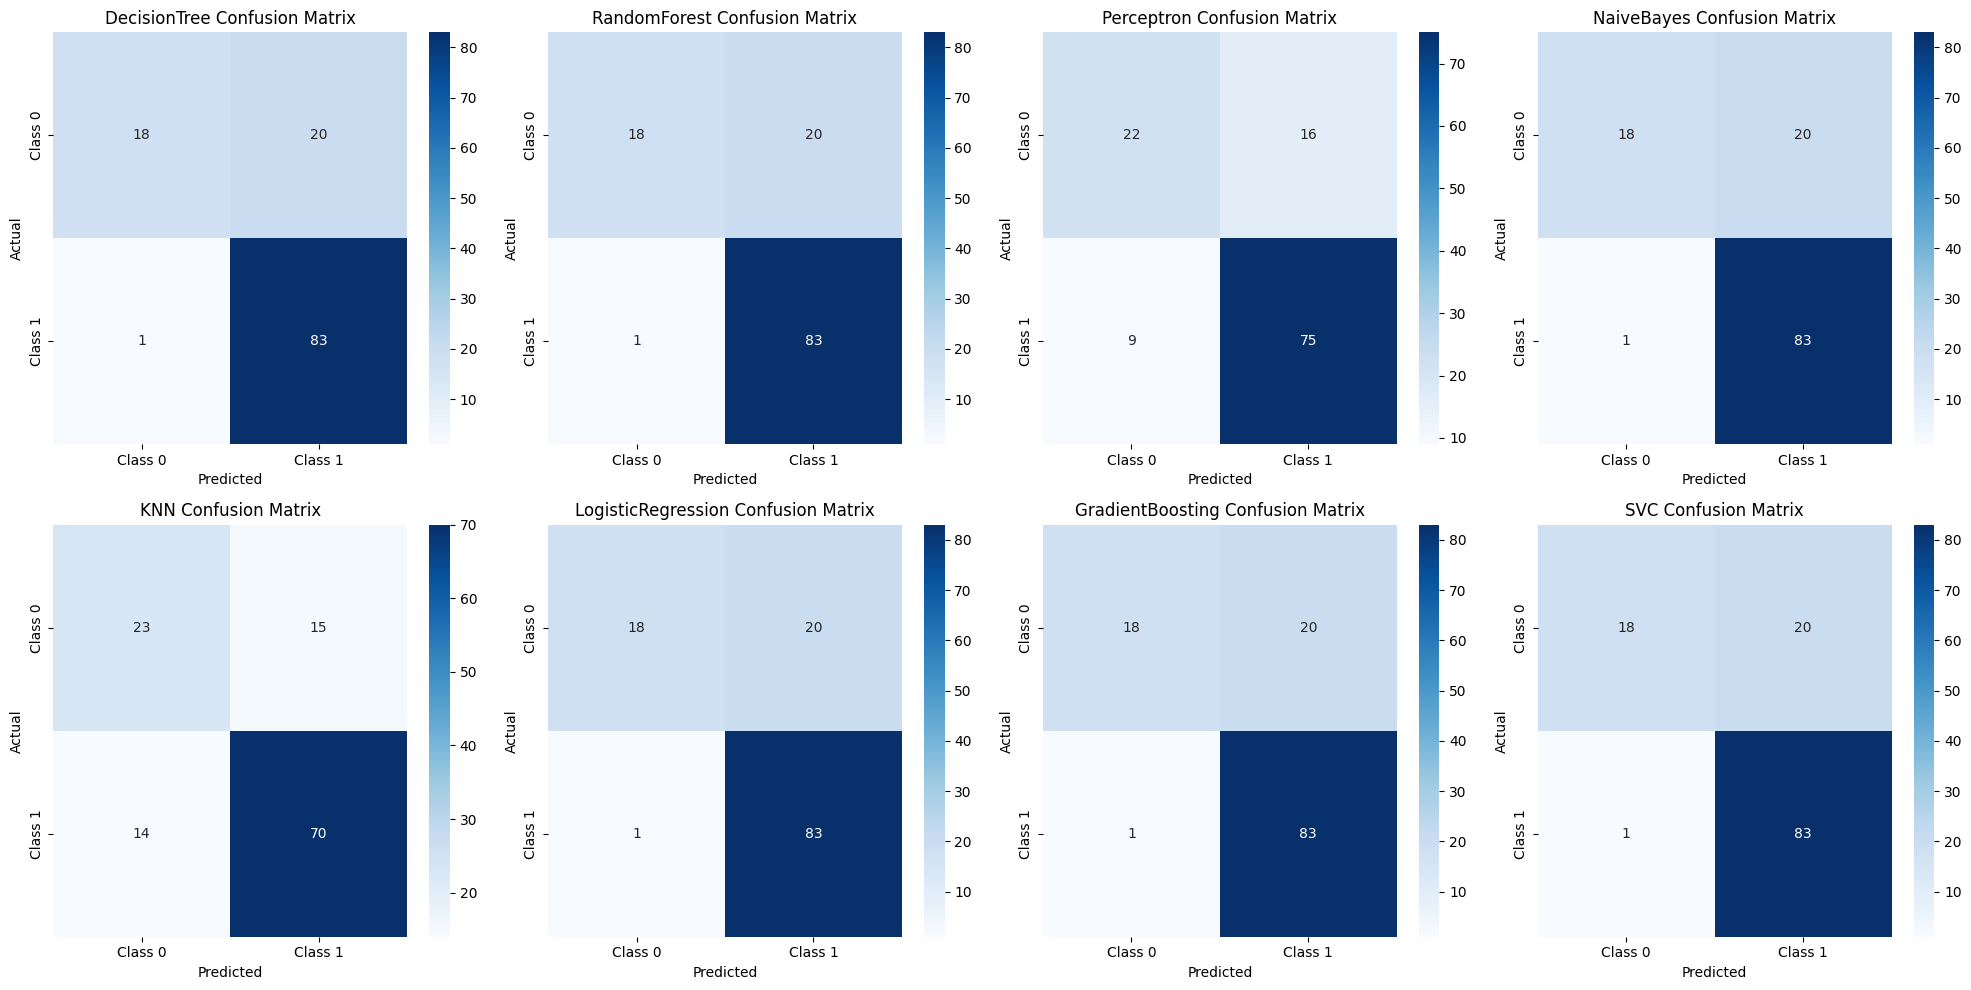

In [ ]:

from sklearn.metrics import confusion_matrix


# Function to plot confusion matrices for each classifier
def plot_confusion_matrices(X_test, y_test):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, config in enumerate(best_configs):
        classifier_name = config["classifier"]
        classifier = classifiers[classifier_name].set_params(**config["params"])

        dim_reduction_name = config["dim_reduction"]
        dim_reduction = dim_reduction_methods[dim_reduction_name].set_params(**config["dim_params"])

        sampling_name = config["sampling"]
        sampler = sampling_methods[sampling_name].set_params(**config["sampling_params"])

        # Build the pipeline
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("dim_reduction", dim_reduction),
            ("sampler", sampler),
            ("classifier", classifier)
        ])

        # Train the pipeline on training set
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"], ax=axes[i])
        axes[i].set_title(f"{classifier_name} Confusion Matrix")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

# Call the function to plot confusion matrices
plot_confusion_matrices(X_test, y_test)


The confusion matrix gives us a good visualization on exact predictions of each classifiers. KNN which had pretty bad performance compared to tree based classifiers, actually has less false positives (15) unlike 20 for the rest of the classifiers, but it has higher false negatives than others. But depending on what matters most, if we care about reducing false positives, and getting a bit more false negatives is acceptable, KNN can be a good classifier in this case.

Let's check the features importance in our dataset that contributed most to the prediction.

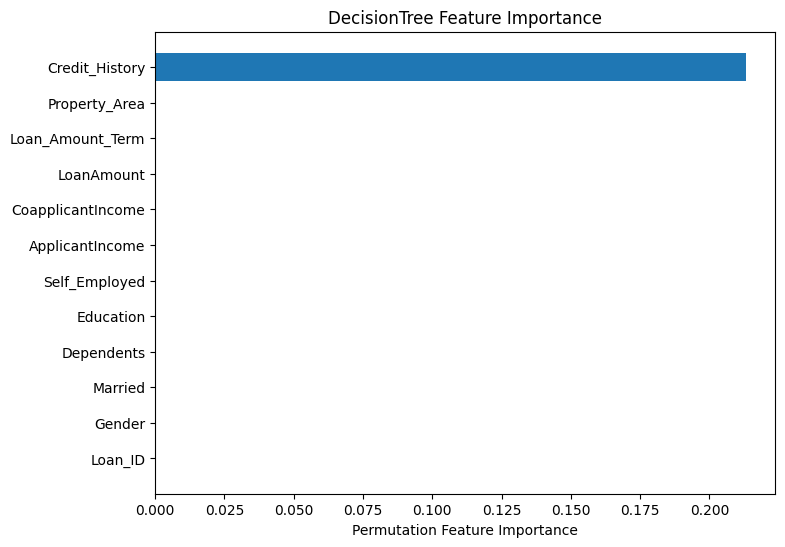

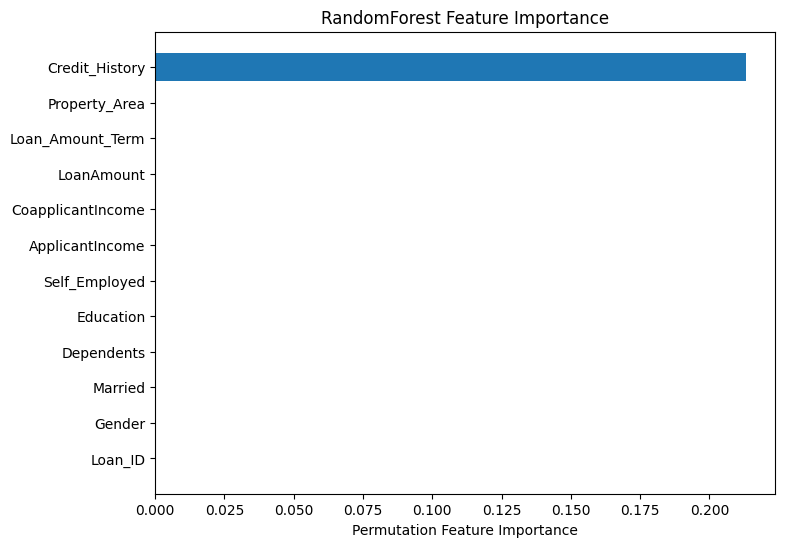

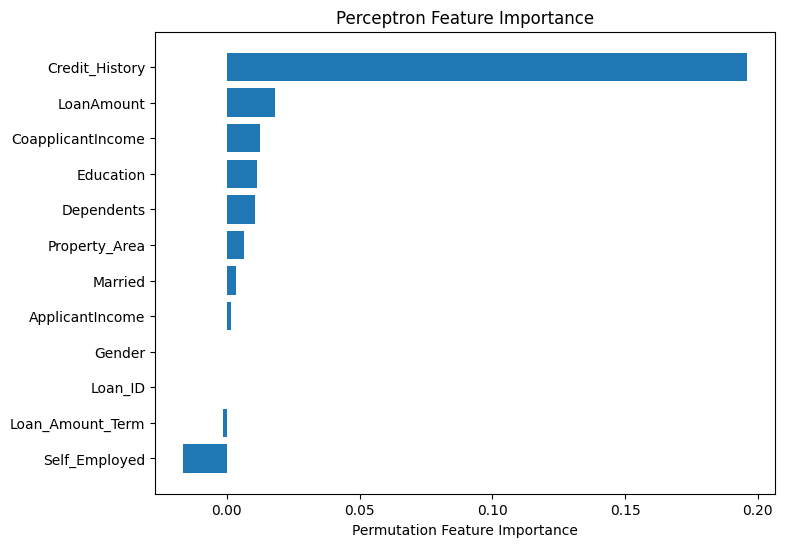

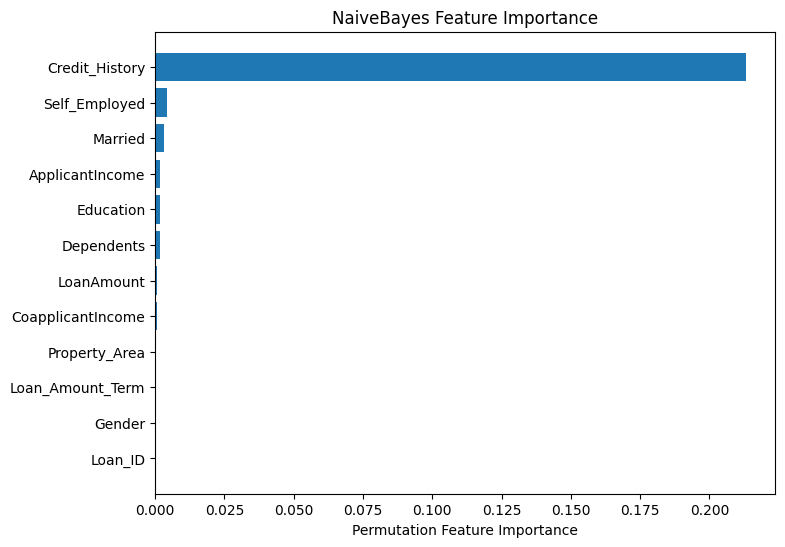

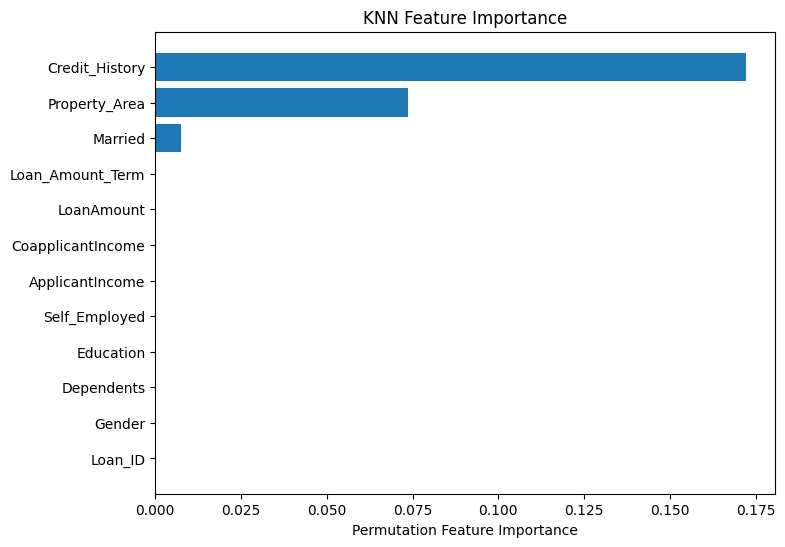

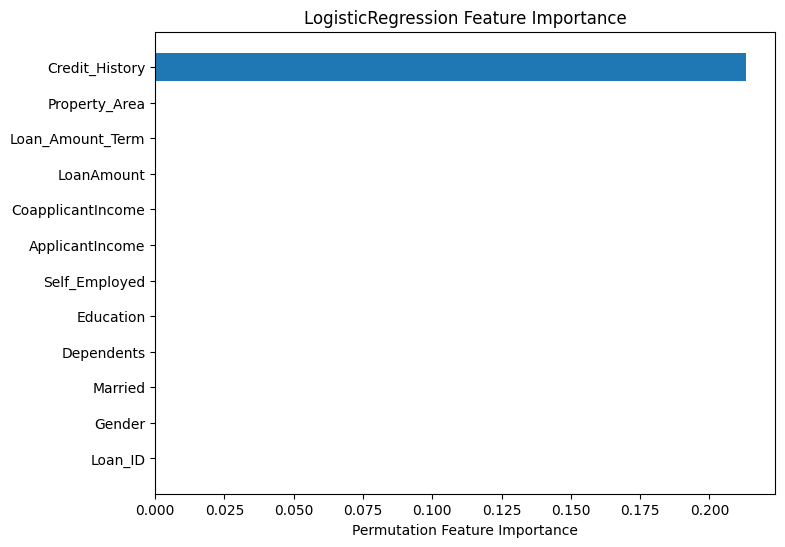

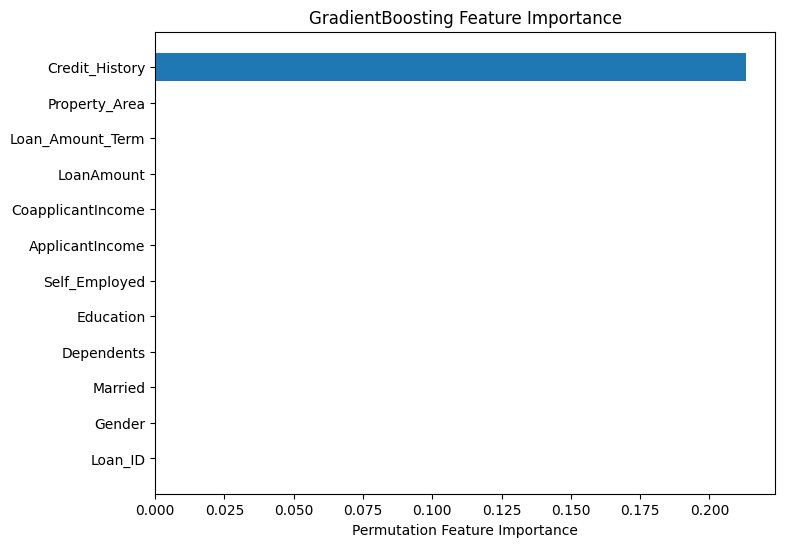

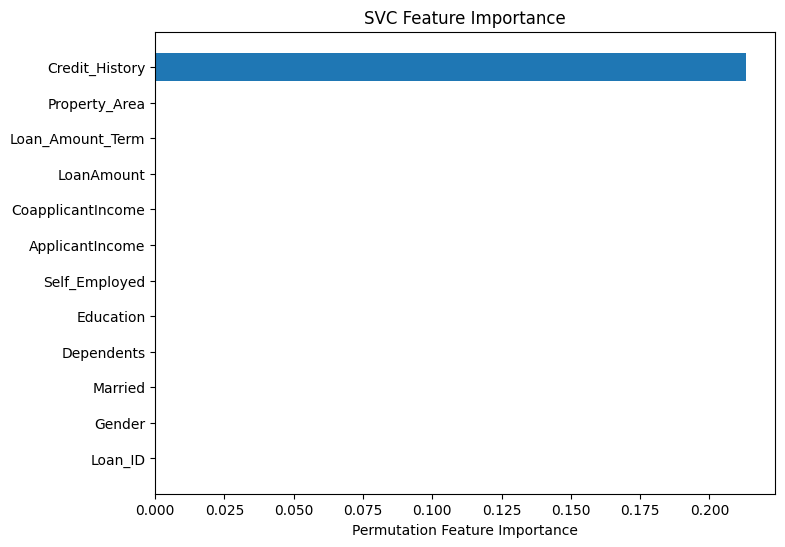

In [ ]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(X_test, y_test):
    for config in best_configs:
        classifier_name = config["classifier"]
        classifier = classifiers[classifier_name].set_params(**config["params"])

        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("dim_reduction", dim_reduction_methods[config["dim_reduction"]].set_params(**config["dim_params"])),
            ("sampler", sampling_methods[config["sampling"]].set_params(**config["sampling_params"])),
            ("classifier", classifier)
        ])

        pipeline.fit(X_train, y_train)

        result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
        sorted_idx = result.importances_mean.argsort()

        plt.figure(figsize=(8, 6))
        plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
        plt.xlabel("Permutation Feature Importance")
        plt.title(f"{classifier_name} Feature Importance")
        plt.show()

plot_permutation_importance(X_test, y_test)


So far, credit history was the most important feature for predictions by almost all classifiers. No wonder banks don't wanna give loan without a good credit history.

Let's try applying these classifiers, after dropping credit history coloumn as all these models maybe biased towards prediction, taking a shortcut, by generalizing only using credit history coloumn, which might lead the model to not generalize well to unseen data, and when credit history data is missing.

Let's first define the coloumn transformer without mentioning credit history coloumn, so it will be dropped as remainders are set to drop.

In [ ]:
# Define individual pipelines for each column
column_pipelines = {
    "LoanAmount": Pipeline([
        ("impute", KNNImputer()),
        ("scale", RobustScaler())
    ]),
    "Loan_Amount_Term": Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", MinMaxScaler())
    ]),

    "Gender": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "Married": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "Dependents": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=[["0", "1", "2", "3+"]]))
    ]),
    "Self_Employed": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "ApplicantIncome": Pipeline([
        ("scale", RobustScaler())  # No imputation needed
    ]),
    "CoapplicantIncome": Pipeline([
        ("scale", RobustScaler())  # No imputation needed
    ]),
    "Property_Area": Pipeline([
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]),
    "Education": Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=[["Not Graduate", "Graduate"]]))
    ])
}

# Apply the column transformations
preprocessor2 = ColumnTransformer(
    transformers=[
        (col, pipeline, [col]) for col, pipeline in column_pipelines.items()
    ],
    remainder="drop"  # drops columns not explicitly listed
)

Now lets recreate the optuna pipeline, just changing the coloumn transformer from preprocessor to this new preprocessor2

In [ ]:
def build_pipeline(trial):
    classifier = get_classifier(trial)
    dim_reduction = get_dim_reduction(trial)
    sampler = get_sampler(trial)

    return ImbPipeline([
        ("preprocessor2", preprocessor),
        ("dim_reduction", dim_reduction),
        ("sampler", sampler),
        ("classifier", classifier)
    ])

In [ ]:
def objective(trial):
    pipeline = build_pipeline(trial)

    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1", error_score="raise")
        mean_score = scores.mean()
    except ValueError as e:
        print(f"Trial failed due to ValueError: {e}")
        return None

    trial.report(mean_score, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return mean_score

In [ ]:
# Run Optuna optimization
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_study.db", study_name="ml_pipeline", load_if_exists=True)
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2025-02-16 18:22:31,730] A new study created in RDB with name: ml_pipeline
[I 2025-02-16 18:22:32,965] Trial 1 finished with value: 0.8211124677199766 and parameters: {'classifier': 'DecisionTree', 'dt_max_depth': 13, 'dim_reduction': 'SelectKBest', 'selectkbest_k': 6, 'sampling': 'SMOTE_Tomek', 'smote_tomek_sampling_strategy': 0.8565928394622647}. Best is trial 1 with value: 0.8211124677199766.
[I 2025-02-16 18:22:33,681] Trial 0 finished with value: 0.7702438203909265 and parameters: {'classifier': 'SVC', 'svc_C': 43.129406775705, 'svc_kernel': 'poly', 'dim_reduction': 'TSVD', 'tsvd_n_components': 6, 'sampling': 'RandomUnderSampling', 'rus_sampling_strategy': 0.5303700879699891}. Best is trial 1 with value: 0.8211124677199766.
[I 2025-02-16 18:22:34,949] Trial 2 finished with value: 0.7869234755475659 and parameters: {'classifier': 'KNN', 'knn_n_neighbors': 11, 'dim_reduction': 'KernelPCA', 'kpca_kernel': 'rbf', 'sampling': 'None'}. Best is trial 1 with value: 0.8211124677199766.


In [ ]:
# Retrieve best results per classifier
best_per_classifier = defaultdict(lambda: (None, -1))
for trial in study.trials:
    clf = trial.params["classifier"]
    if trial.value is not None and trial.value > best_per_classifier[clf][1]:
        best_per_classifier[clf] = (trial.params, trial.value)

# Print the best results
print("Best overall trial:", study.best_trial.params)
print("Best overall F1-score:", study.best_trial.value)
print("\nBest combination per classifier:")
for clf, (params, score) in best_per_classifier.items():
    print(f"Classifier: {clf}, Best F1-score: {score}, Params: {params}")

Best overall trial: {'classifier': 'RandomForest', 'rf_n_estimators': 100, 'rf_max_depth': 3, 'dim_reduction': 'SelectKBest', 'selectkbest_k': 2, 'sampling': 'ADASYN', 'adasyn_sampling_strategy': 0.8331353456967974}
Best overall F1-score: 0.8699456484348126

Best combination per classifier:
Classifier: SVC, Best F1-score: 0.8699456484348126, Params: {'classifier': 'SVC', 'svc_C': 2.032165709550556, 'svc_kernel': 'rbf', 'dim_reduction': 'SelectKBest', 'selectkbest_k': 2, 'sampling': 'SMOTE_Tomek', 'smote_tomek_sampling_strategy': 0.9858536421373453}
Classifier: DecisionTree, Best F1-score: 0.8699456484348126, Params: {'classifier': 'DecisionTree', 'dt_max_depth': 4, 'dim_reduction': 'SelectKBest', 'selectkbest_k': 3, 'sampling': 'ADASYN', 'adasyn_sampling_strategy': 0.8806035433890775}
Classifier: KNN, Best F1-score: 0.8216589725542791, Params: {'classifier': 'KNN', 'knn_n_neighbors': 15, 'dim_reduction': 'None', 'sampling': 'None'}
Classifier: LogisticRegression, Best F1-score: 0.86994

lets create dictionary with name best_configs2 and this will have the above best combination, which we got without including credit history feature. If tree based models, and other models which seemed to take credit history as very important feature fails to get a good f1 score now in outer cross validation evaluation, we can conclude that they were overfitting to that 1 feature. If they still have a good f1 score, it means the above model was not overfitting using only 1 feature and is good enough to generalize on unseen datas.

In [ ]:
best_configs2 = [
    {
        "classifier": "SVC",
        "params": {"C": 2.032165709550556, "kernel": "rbf"},
        "dim_reduction": "SelectKBest",
        "dim_params": {"k": 2},
        "sampling": "SMOTE_Tomek",
        "sampling_params": {"sampling_strategy": 0.9858536421373453}
    },
    {
        "classifier": "DecisionTree",
        "params": {"max_depth": 4},
        "dim_reduction": "SelectKBest",
        "dim_params": {"k": 3},
        "sampling": "ADASYN",
        "sampling_params": {"sampling_strategy": 0.8806035433890775}
    },
    {
        "classifier": "KNN",
        "params": {"n_neighbors": 15},
        "dim_reduction": "None",
        "dim_params": {},
        "sampling": "None",
        "sampling_params": {}
    },
    {
        "classifier": "LogisticRegression",
        "params": {"C": 60.943154557699714},
        "dim_reduction": "SelectKBest",
        "dim_params": {"k": 3},
        "sampling": "RandomUnderSampling",
        "sampling_params": {"sampling_strategy": 0.5068127165637559}
    },
    {
        "classifier": "Perceptron",
        "params": {"alpha": 1.4821688169328418e-05},
        "dim_reduction": "LDA",
        "dim_params": {},
        "sampling": "RandomUnderSampling",
        "sampling_params": {"sampling_strategy": 0.6608249224374783}
    },
    {
        "classifier": "RandomForest",
        "params": {"n_estimators": 100, "max_depth": 3},
        "dim_reduction": "SelectKBest",
        "dim_params": {"k": 2},
        "sampling": "ADASYN",
        "sampling_params": {"sampling_strategy": 0.8331353456967974}
    },
    {
        "classifier": "GradientBoosting",
        "params": {"n_estimators": 450, "learning_rate": 0.013019890779918261},
        "dim_reduction": "LDA",
        "dim_params": {},
        "sampling": "RandomUnderSampling",
        "sampling_params": {"sampling_strategy": 0.8825252582956618}
    },
    {
        "classifier": "NaiveBayes",
        "params": {},
        "dim_reduction": "LDA",
        "dim_params": {},
        "sampling": "ADASYN",
        "sampling_params": {"sampling_strategy": 0.7124842739842153}
    }
]


In [ ]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store overall results
results = {}

for config in best_configs2:
    classifier_name = config["classifier"]
    classifier = classifiers[classifier_name].set_params(**config["params"])

    dim_reduction_name = config["dim_reduction"]
    if dim_reduction_name == "None":
        dim_reduction = None  # Assign None directly if dim_reduction is "None"
    else:
         dim_reduction = dim_reduction_methods[dim_reduction_name].set_params(**config["dim_params"])

    sampling_name = config["sampling"]
    if sampling_name == "None":
        sampler = None
    else:
        sampler = sampling_methods[sampling_name].set_params(**config["sampling_params"])

    # Store metrics across folds
    accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, pr_auc_list = [], [], [], [], [], []

    # Perform outer cross-validation
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]  # ✅ Works for NumPy arrays


        # Build the pipeline
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor2),
            ("dim_reduction", dim_reduction),
            ("sampler", sampler),
            ("classifier", classifier)
        ])

        # Train and evaluate
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Get probability or decision function for AUC calculations
        if hasattr(classifier, "predict_proba"):
            y_scores = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class
        elif hasattr(classifier, "decision_function"):
            y_scores = pipeline.decision_function(X_test)  # Use decision function as scores
        else:
            y_scores = None  # Some classifiers neither support predict_proba nor decision_function

        # Compute metrics for this fold
        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred, zero_division=0))
        recall_list.append(recall_score(y_test, y_pred, zero_division=0))
        f1_list.append(f1_score(y_test, y_pred))
        if y_scores is not None:
            roc_auc_list.append(roc_auc_score(y_test, y_scores))
            pr_auc_list.append(average_precision_score(y_test, y_scores))

    # Store the averaged results over all folds
    results[classifier_name] = {
        "Accuracy": np.mean(accuracy_list),
        "Precision": np.mean(precision_list),
        "Recall": np.mean(recall_list),
        "F1 Score": np.mean(f1_list),
        "ROC AUC": np.mean(roc_auc_list) if roc_auc_list else None,
        "PR AUC": np.mean(pr_auc_list) if pr_auc_list else None
    }

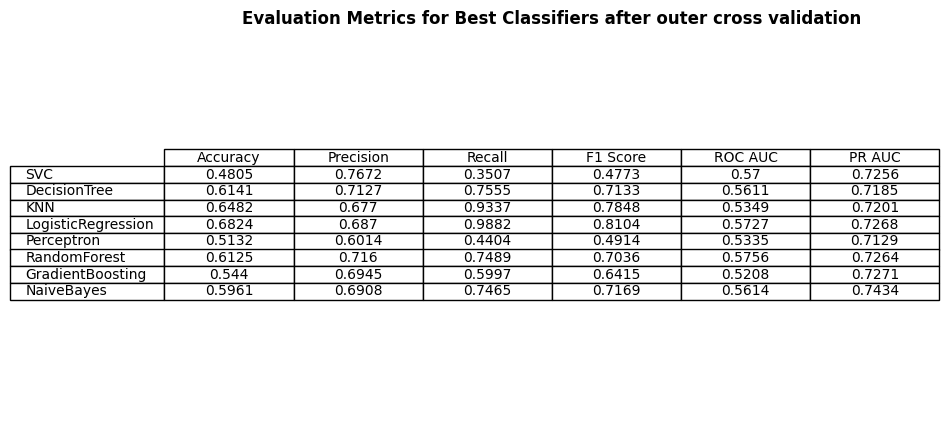

In [ ]:
# Convert results dictionary into a DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index")

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=results_df.round(4).values,  # Round values to 4 decimal places
                 colLabels=results_df.columns,  # Column headers
                 rowLabels=results_df.index,  # Row labels (Classifier names)
                 cellLoc='center',  # Center-align text
                 loc='center')  # Place table in the center

# Add a title
plt.title("Evaluation Metrics for Best Classifiers after outer cross validation", fontsize=12, fontweight="bold")

# Show the table
plt.show()

Even after removing credit history feature, the tree based models and logistic regression which showed higher feature importance to credit history are still doing pretty good with f1 scores above 0.80, compared to percerptron which took into account for other features as well during predictions before, and this time without credit history feature, has lower f1 score. From this I can conclude that the tree based models were not overfitting to a single feature ' credit history', but it is the dataset that itself has a  biased pattern, and most other features are less relevant than credit history.
But it seems like SVC was actually overfitting to credit history feature, now that we excluded credit history from the dataset and applied SVC, the f1 score got really low, the lowest among all classifiers. But perhaps, using more trials with optuna could tune it better, which can be done by running optuna more times , but we won't be doing it to save resources